In [8]:
import os 
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import skimage.io as io

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchsummary import summary

from Model.UNetAttentionResNet import UNetAttentionResNet
from Model.UNetAttentionDenseNet import UNetAttentionDenseNet
from Model.UNetAttentionEfficientV2 import UNetAttentionEfficientV2
from Model.UNetEfficientNetV2 import UNetEfficientV2

from diodetools.DiodeLoader import DiodeDataLoader
from diodetools.TrainTest import test, load_state

## Load model

In [2]:
device = torch.device("cuda")

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

In [ ]:
# Pengujian setiap model Attention U-Net dengan Pre-Trained
res18   = load_model(
    UNetAttentionResNet(device, 'resnet18'), 
    r'./SavedModel/resnet/resnet18_50_epoch_26-04-23.pt')
res34   = load_model(
    UNetAttentionResNet(device, 'resnet34'), 
    r'./SavedModel/resnet/resnet34_50_epoch_26-04-23.pt')
res50   = load_model(
    UNetAttentionResNet(device, 'resnet50'), 
    r'./SavedModel/resnet/resnet50_50_epoch_27-04-23.pt')
res101  = load_model(
    UNetAttentionResNet(device, 'resnet101'), 
    r'./SavedModel/resnet/resnet101_50_epoch_27-04-23.pt')
res152  = load_model(
    UNetAttentionResNet(device, 'resnet152'), 
    r'./SavedModel/resnet/resnet152_50_epoch_27-04-23.pt')

den121  = load_model(
    UNetAttentionDenseNet(device, 'densenet121'), 
    r'./SavedModel/densenet/densenet121_50_epoch_26-04-23.pt')
den169  = load_model(
    UNetAttentionDenseNet(device, 'densenet169'), 
    r'./SavedModel/densenet/densenet169_50_epoch_26-04-23.pt')
den169_a  = load_model(
    UNetAttentionDenseNet(device, 'densenet169', act=True), 
    r'./SavedModel/densenet/densenet169_act_50_epoch_25-04-23.pt')
den201  = load_model(
    UNetAttentionDenseNet(device, 'densenet201'), 
    r'./SavedModel/densenet/densenet201_50_epoch_26-04-23.pt')

u_v2_s = load_model(
    UNetAttentionEfficientV2(device, 'efficient_v2_s'), 
    r'./SavedModel/efficientnet/efficient_v2_s_50_epoch_28-04-23.pt')
u_v2_m = load_model(
    UNetAttentionEfficientV2(device, 'efficient_v2_m'), 
    r'./SavedModel/efficientnet/efficient_v2_m_50_epoch_28-04-23.pt')
u_v2_l = load_model(
    UNetAttentionEfficientV2(device, 'efficient_v2_l'), 
    r'./SavedModel/efficientnet/efficient_v2_l_50_epoch_28-04-23.pt')

In [ ]:
# Pengujian model arsitektur U-Net dengan Attention U-Net
u_v2_s = load_model(
    UNetAttentionEfficientV2(device, 'efficient_v2_s'), 
    r'./SavedModel/efficientnet/efficient_v2_s_50_epoch_28-04-23.pt')
u_v2_m = load_model(
    UNetAttentionEfficientV2(device, 'efficient_v2_m'), 
    r'./SavedModel/efficientnet/efficient_v2_m_50_epoch_28-04-23.pt')
u_v2_l = load_model(
    UNetAttentionEfficientV2(device, 'efficient_v2_l'), 
    r'./SavedModel/efficientnet/efficient_v2_l_50_epoch_28-04-23.pt')

noag_u_v2_s = load_model(
    UNetEfficientV2(device, 'efficient_v2_s'), 
    r'./SavedModel/noag_efficientnet/NoAG_UNet_efficient_v2_s_50_epoch_28-04-23.pt')
noag_u_v2_m = load_model(
    UNetEfficientV2(device, 'efficient_v2_m'), 
    r'./SavedModel/noag_efficientnet/NoAG_UNet_efficient_v2_m_50_epoch_28-04-23.pt')
noag_u_v2_l = load_model(
    UNetEfficientV2(device, 'efficient_v2_l'), 
    r'./SavedModel/noag_efficientnet/NoAG_UNet_efficient_v2_l_50_epoch_28-04-23.pt')

In [3]:
# Pengujian pengaruh fungsi aktivasi di head block 
den169_no  = load_model(
    UNetAttentionDenseNet(device, 'densenet169', act=False), 
    r'./SavedModel/densenet/densenet169_50_epoch_26-04-23.pt')

den169_act  = load_model(
    UNetAttentionDenseNet(device, 'densenet169', act=True), 
    r'./SavedModel/densenet/densenet169_act_50_epoch_26-04-23.pt')

## Data Preparation

In [7]:
torch.random.manual_seed(1)

def getData(path):
    filelist = []

    for root, dirs, files in os.walk(path):
        for file in files:
            filelist.append(os.path.join(root, file))

    filelist.sort()
    data = {
        "image": [x for x in filelist if x.endswith(".png")],
        "depth": [x for x in filelist if x.endswith("_depth.npy")],
        "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
    }
    
    df = pd.DataFrame(data)
    return df

df_test = getData(r'../datasets/diode/val/indoors/')
df_outdoor_test = getData(r'../datasets/diode/val/outdoor/')
print(f"Test indoor : {df_test.shape}")
print(f"Test outdoor : {df_outdoor_test.shape}")

Test indoor : (325, 3)
Test outdoor : (446, 3)


## Quantitative Comparison

### ResNet Variant

In [ ]:
torch.random.manual_seed(1)
np.random.seed(1)

max_depth = 50
models = [res18, res34, res50, res101, res152]
models_name = ['res-18', 'res-34', 'res-50', 'res-101', 'res-152']

def testing_all_model(loader, models, models_name, max_depth):
    for model, model_name in zip(models, models_name):
        print(model_name)
        test(model=model, l1_weight=0.1, loader=loader, max_depth=max_depth, device='cuda')
        print()
        
        del model

testloader = DataLoader(
                    DiodeDataLoader(df_test, max_depth=max_depth, img_dim=(192, 256), depth_dim=(192, 256)), 
                    batch_size=16, 
                    shuffle=False
                )

testing_all_model(testloader, models, models_name, max_depth)
torch.cuda.empty_cache()

### DenseNet Variant

In [ ]:
torch.random.manual_seed(1)
np.random.seed(1)

max_depth = 50
models = [den121, den169, den201]
models_name = ['den-121', 'den-169', 'den-201']

def testing_all_model(loader, models, models_name, max_depth):
    for model, model_name in zip(models, models_name):
        print(model_name)
        test(model=model, l1_weight=0.1, loader=loader, max_depth=max_depth, device='cuda')
        print()
        
        del model

testloader = DataLoader(
                    DiodeDataLoader(df_test, max_depth=max_depth, img_dim=(192, 256), depth_dim=(192, 256)), 
                    batch_size=16, 
                    shuffle=False
                )

testing_all_model(testloader, models, models_name, max_depth)
torch.cuda.empty_cache()

### DenseNet with act

In [ ]:
torch.random.manual_seed(1)
np.random.seed(1)

max_depth = 50
testloader = DataLoader(
                    DiodeDataLoader(df_test, max_depth=max_depth, img_dim=(192, 256), depth_dim=(192, 256)), 
                    batch_size=16, 
                    shuffle=True
                )

print(f'den169_a')
test(model=den169_a, l1_weight=0.1, loader=testloader, max_depth=max_depth, device='cuda')
torch.cuda.empty_cache()

### EfficientNet V2 Variant

In [ ]:
torch.random.manual_seed(1)
np.random.seed(1)

max_depth = 50
models = [ef_s, ef_m, ef_l]
models_name = ['ef-V2-s', 'ef-V2-m', 'ef-V2-l']

def testing_all_model(loader, models, models_name, max_depth):
    for model, model_name in zip(models, models_name):
        print(model_name)
        test(model=model, l1_weight=0.1, loader=loader, max_depth=max_depth, device='cuda')
        print()
        
        del model

testloader = DataLoader(
                    DiodeDataLoader(df_test, max_depth=max_depth, img_dim=(192, 256), depth_dim=(192, 256)), 
                    batch_size=32, 
                    shuffle=False
                )

testing_all_model(testloader, models, models_name, max_depth)
torch.cuda.empty_cache()

### No AG - EfficientNet V2 Variant

In [ ]:
torch.random.manual_seed(1)
np.random.seed(1)

max_depth = 50
models = [u_v2_s, u_v2_m, u_v2_l]
models_name = ['UE-S', 'UE-M', 'UE-L']

def testing_all_model(loader, models, models_name, max_depth):
    for model, model_name in zip(models, models_name):
        print(model_name)
        test(model=model, l1_weight=0.1, loader=loader, max_depth=max_depth, device='cuda')
        print()
        
        del model

testloader = DataLoader(
                    DiodeDataLoader(df_test, max_depth=max_depth, img_dim=(192, 256), depth_dim=(192, 256)), 
                    batch_size=32, 
                    shuffle=False
                )

testing_all_model(testloader, models, models_name, max_depth)
torch.cuda.empty_cache()

## Visualization

In [8]:
torch.random.manual_seed(42)

max_depth = 50
loader = DataLoader(
            DiodeDataLoader(df_test, max_depth=max_depth, img_dim=(192, 256), depth_dim=(192, 256)), 
            batch_size=128, 
            shuffle=False
        )

In [9]:
data, depth = next(iter(loader))
print(f"Data : {data.shape}")
print(f"Depth: {depth.shape}")

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Data : torch.Size([128, 3, 192, 256])
Depth: torch.Size([128, 1, 192, 256])


In [10]:
# visualize 
def visualize(show_idx, models, models_name, cmap='inferno'):
    with torch.no_grad():
        fig, ax = plt.subplots(nrows=1, ncols=2 + len(models), figsize=(24, 22))
        ax[0].set_title('Image', fontsize=15)
        ax[1].set_title('DepthMap (GT)', fontsize=15)
        
        ax[0].imshow(data[show_idx].permute(1, 2, 0))
        ax[1].imshow(depth[show_idx].squeeze(), cmap=cmap)
        
        start_show_idx = 2
        for model, model_name in (zip(models, models_name)):
            model.eval()
            ax[start_show_idx].set_title(model_name, fontsize=14)
            pred = model(data[show_idx][np.newaxis].to(device)).squeeze().cpu()
            ax[start_show_idx].imshow(pred, cmap=cmap)
        
            start_show_idx += 1
        
        plt.show()

In [ ]:
cmap = 'inferno'

for idx in range(128):
    print(f'[{idx}]---'*20)
    visualize(idx, 
        [den169_no, den169_act], 
        ['DenseNet-169 [No Act]', 'DenseNet-169 [With Act]'], 
        cmap=cmap
    )
    # visualize(idx, 
    #             [res18, res34, res50, res101, res152], 
    #             ['ResNet-18', 'ResNet-34', 'ResNet-50', 'ResNet-101', 'ResNet-152'], 
    #             cmap=cmap)
    # visualize(idx, 
    #             [den121, den169, den201], 
    #             ['DenseNet-121', 'DenseNet-169', 'DenseNet-201'], 
    #             cmap=cmap)
    # visualize(idx, 
    #             [u_v2_s, u_v2_m, u_v2_l], 
    #             ['EfficientNet-V2-S [U]', 'EfficientNet-V2-M [U]', 'EfficientNet-V2-L [U]'], 
    #             cmap=cmap)
    # visualize(idx, 
    #             [noag_u_v2_s, noag_u_v2_m, noag_u_v2_l], 
    #             ['EfficientNet-V2-S [W]', 'EfficientNet-V2-M [W]', 'EfficientNet-V2-L [W]'], 
    #             cmap=cmap)
    print('---'*20)

## Custom image

In [ ]:
# visualize 
def custom_visualize(img_path, models, models_name, device, cmap='inferno'):
    with torch.no_grad():
        trans = transforms.Compose([
                        transforms.ToTensor(), 
                        transforms.Resize((256, 256))
                    ])
        img = io.imread(img_path)
        img = trans(img[:, :, :3]).to(device)
        
        start_show_idx = 1
        fig, ax = plt.subplots(nrows=1, ncols=start_show_idx+len(models), figsize=(16, 22))
        ax[0].set_title('Image', fontsize=15)
        ax[0].imshow(img.permute(1, 2, 0).cpu())
        
        for model, model_name in (zip(models, models_name)):
            model.eval()
            ax[start_show_idx].set_title(model_name, fontsize=15)
            pred = model(img[None, :, :, :]).squeeze().cpu()
            ax[start_show_idx].imshow(pred, cmap=cmap)
        
            start_show_idx += 1
        
        plt.show()

custom_visualize(
    img_path='./TestSample/uji (1).png', 
    models=models, 
    models_name=models_name, 
    device=device,
    cmap='inferno'
)

## Training Visualization

In [ ]:
import re 

model_name = ['DenseNet-121', 'DenseNet-169', 'DenseNet-169 [Act]', 'DenseNet-201', 
                'ResNet-101', 'ResNet-152', 'ResNet-18', 'ResNet-34', 'ResNet-50']
df_readed = [] 

for path in os.listdir('./TrainingHistory/'): 
    print(path)
    df_readed.append(pd.read_csv('./TrainingHistory/' + path))

In [ ]:
# Show RMSE
show_cols = ['rmse', 'rel', 'acc_1', 'acc_2', 'acc_3']
est_cols = ['RMSE', 'REL', '$\delta$ < 1.25', '$\delta$ < 1.25^2', '$\delta$ < 1.25^3']

figsize_show_per_row = (20, 45)
figsize_show_per_cols = (30, 6)

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=figsize_show_per_row)
for i in range(len(show_cols)):
    ax[i].set_title(est_cols[i], fontsize=15)
    ax[i].grid(True)
    for df, model in zip(df_readed, model_name): 
        ax[i].plot(df[show_cols[i]][39:], label=model, lw=2)

    ax[i].legend()

## Real time Viz

In [3]:
# Pengujian pengaruh fungsi aktivasi di head block 
# kasih nama "model"
den169_no  = load_model(
    UNetAttentionDenseNet(device, 'densenet169', act=False), 
    r'./SavedModel/densenet/densenet169_50_epoch_26-04-23.pt')

den169_act  = load_model(
    UNetAttentionDenseNet(device, 'densenet169', act=True), 
    r'./SavedModel/densenet/densenet169_act_50_epoch_26-04-23.pt')

In [8]:
import cv2
from torchvision.transforms import transforms
import time

cap = cv2.VideoCapture(0)
prev_frame_time, new_frame_time = 0., 0.

width, height = cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

down_resizer = transforms.Resize(size=(192, 256))
up_resizer = transforms.Resize(size=(int(height), int(width)))

max_depth = 50.
inference_time_history = []
inference_fps_history = []

prev_frame_time = 0
new_frame_time = 0
elapsed_time = time.time()
font = cv2.FONT_HERSHEY_SIMPLEX
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()
    if success:
        processed_frame = torch.tensor(np.array([frame])).permute(0, 3, 1, 2).to(device) / 255.
        processed_mde_frame = down_resizer(processed_frame).to(device)
        
        # mde_output = up_resizer(mde_model(processed_mde_frame))[0][0]
        inference_starttime = time.time()
        #! Konfigurasi model disini
        pred = den169_no(processed_mde_frame)
        inference_endtime = time.time()
        inference_time_history.append(inference_endtime - inference_starttime)
        
        new_frame_time = time.time() 
        fps = 1/(new_frame_time-prev_frame_time) 
        prev_frame_time = new_frame_time 
        fps = str(int(fps))
        inference_fps_history.append(fps)
        
        mde_output = up_resizer(pred)[0][0]
        mde_output = mde_output * max_depth
        pred_color = ((mde_output - mde_output.min()) / (mde_output.max() - mde_output.min()) * 255)
        pred_color = pred_color.cpu().detach().numpy()
        pred_color = cv2.applyColorMap(pred_color.astype('uint8'), cv2.COLORMAP_INFERNO)
        
        cv2.putText(pred_color, f"FPS : {fps}", (7, 70), font, 3, (100, 255, 0), 2, cv2.LINE_AA) 
        cv2.imshow("RGB Input", frame)
        cv2.imshow("DepthMap Inference", pred_color)

        # Break the loop if 'q' is pressed
        done = int(time.time() - elapsed_time) == 9999
        if cv2.waitKey(1) & 0xFF == ord("q") or done:
            break
    else:
        break

cap.release()

cv2.destroyAllWindows()

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [67]:
print(f"GPU - Dense169 No Act")
print('---'*10)
print(f"Inference TIME history: ")
print(f"first 100 : {inference_time_history[:100]}")
print(f"Mean   : {np.array(inference_time_history).mean()}")
print(f"Median : {np.median(np.array(inference_time_history))}")
print('---'*10)
print(f"Inference FPS history: ")
print(f"first 100 : {inference_fps_history[:100]}")
print(f"Mean   : {np.array(inference_fps_history, dtype=np.int16).mean()}")
print(f"Median : {np.median(np.array(inference_fps_history, dtype=np.int16))}")

GPU - Dense169 No Act
------------------------------
Inference TIME history: 
first 100 : [0.06483316421508789, 0.04733538627624512, 0.052243709564208984, 0.04712820053100586, 0.0510258674621582, 0.04224586486816406, 0.0519256591796875, 0.04537820816040039, 0.04445838928222656, 0.047458648681640625, 0.04638957977294922, 0.04155731201171875, 0.045577049255371094, 0.044261932373046875, 0.0483705997467041, 0.04857945442199707, 0.04734659194946289, 0.04752373695373535, 0.04270029067993164, 0.04545998573303223, 0.05310845375061035, 0.0413663387298584, 0.04220438003540039, 0.041570186614990234, 0.04124808311462402, 0.04930567741394043, 0.04368782043457031, 0.048261165618896484, 0.04509758949279785, 0.045656442642211914, 0.04411673545837402, 0.048723697662353516, 0.046762943267822266, 0.0444638729095459, 0.043590545654296875, 0.04419684410095215, 0.04396200180053711, 0.045903682708740234, 0.045479774475097656, 0.04401683807373047, 0.04131770133972168, 0.05195188522338867, 0.04407143592834473,

In [69]:
print(f"GPU - Dense169 With Act")
print('---'*10)
print(f"Inference TIME history: ")
print(f"first 100 : {inference_time_history[:100]}")
print(f"Mean   : {np.array(inference_time_history).mean()}")
print(f"Median : {np.median(np.array(inference_time_history))}")
print('---'*10)
print(f"Inference FPS history: ")
print(f"first 100 : {inference_fps_history[:100]}")
print(f"Mean   : {np.array(inference_fps_history, dtype=np.int16).mean()}")
print(f"Median : {np.median(np.array(inference_fps_history, dtype=np.int16))}")

GPU - Dense169 With Act
------------------------------
Inference TIME history: 
first 100 : [0.04695391654968262, 0.041591644287109375, 0.052107810974121094, 0.05348777770996094, 0.04865217208862305, 0.04351401329040527, 0.0447232723236084, 0.044267892837524414, 0.03969979286193848, 0.04480481147766113, 0.045406341552734375, 0.04595303535461426, 0.06192207336425781, 0.04684305191040039, 0.04860734939575195, 0.04568886756896973, 0.04763960838317871, 0.04757404327392578, 0.04561328887939453, 0.045973777770996094, 0.04426217079162598, 0.041623830795288086, 0.04126310348510742, 0.05849599838256836, 0.04195690155029297, 0.043096303939819336, 0.04178428649902344, 0.04846334457397461, 0.040204763412475586, 0.04697537422180176, 0.04510140419006348, 0.04494357109069824, 0.04150557518005371, 0.04117131233215332, 0.04754137992858887, 0.0445706844329834, 0.042374372482299805, 0.04101848602294922, 0.04434466361999512, 0.04394197463989258, 0.04094862937927246, 0.04858541488647461, 0.0460100173950195

In [9]:
print(f"CPU - Dense169 No Act")
print('---'*10)
print(f"Inference TIME history: ")
print(f"first 100 : {inference_time_history[:100]}")
print(f"Mean   : {np.array(inference_time_history).mean()}")
print(f"Median : {np.median(np.array(inference_time_history))}")
print('---'*10)
print(f"Inference FPS history: ")
print(f"first 100 : {inference_fps_history[:100]}")
print(f"Mean   : {np.array(inference_fps_history, dtype=np.int16).mean()}")
print(f"Median : {np.median(np.array(inference_fps_history, dtype=np.int16))}")

CPU - Dense169 No Act
------------------------------
Inference TIME history: 
first 100 : [0.5262935161590576, 0.5190770626068115, 0.5224490165710449, 0.5101594924926758, 0.5230436325073242, 0.5121700763702393, 0.505425214767456, 0.5272402763366699, 0.5401570796966553, 0.5262546539306641, 0.5223908424377441, 0.5118429660797119, 0.49611830711364746, 0.5438647270202637, 0.5300309658050537, 0.4918191432952881, 0.45496082305908203, 0.47216248512268066, 0.46979475021362305, 0.4504714012145996, 0.48539090156555176, 0.45993852615356445, 0.4789109230041504, 0.46024298667907715, 0.4696178436279297, 0.5038902759552002, 0.5176773071289062, 0.5033471584320068, 0.4846529960632324, 0.5313174724578857, 0.5314376354217529, 0.47928285598754883, 0.5047035217285156, 0.44310569763183594, 0.4431922435760498, 0.46878767013549805, 0.47182297706604004, 0.4660048484802246, 0.45532965660095215, 0.4368577003479004, 0.4482455253601074, 0.45197296142578125, 0.47170567512512207, 0.45232701301574707, 0.4535725116729

In [5]:
print(f"CPU - Dense169 With Act")
print('---'*10)
print(f"Inference TIME history: ")
print(f"first 100 : {inference_time_history[:100]}")
print(f"Mean   : {np.array(inference_time_history).mean()}")
print(f"Median : {np.median(np.array(inference_time_history))}")
print('---'*10)
print(f"Inference FPS history: ")
print(f"first 100 : {inference_fps_history[:100]}")
print(f"Mean   : {np.array(inference_fps_history, dtype=np.int16).mean()}")
print(f"Median : {np.median(np.array(inference_fps_history, dtype=np.int16))}")

CPU - Dense169 No Act
------------------------------
Inference TIME history: 
first 100 : [0.6051533222198486, 0.5283207893371582, 0.5023379325866699, 0.5261940956115723, 0.5406365394592285, 0.5500223636627197, 0.5279295444488525, 0.5205621719360352, 0.5181512832641602, 0.535017728805542, 0.5432651042938232, 0.5181839466094971, 0.5475635528564453, 0.5119552612304688, 0.5495162010192871, 0.5416994094848633, 0.5161535739898682, 0.5486240386962891, 0.4540979862213135, 0.4520761966705322, 0.47326064109802246, 0.4770956039428711, 0.5126292705535889, 0.4666292667388916, 0.4626476764678955, 0.48770785331726074, 0.45062780380249023, 0.4706284999847412, 0.4646482467651367, 0.4726529121398926, 0.46959948539733887, 0.4931173324584961, 0.4691164493560791, 0.4750971794128418, 0.4680898189544678, 0.49671125411987305, 0.4844231605529785, 0.5066711902618408, 0.503636360168457, 0.5276827812194824, 0.5066385269165039, 0.5632688999176025, 0.4826009273529053, 0.4626476764678955, 0.44463491439819336, 0.441

## Visualize Inference time

In [11]:
gpu_it_noact = [0.06483316421508789, 0.04733538627624512, 0.052243709564208984, 0.04712820053100586, 0.0510258674621582, 0.04224586486816406, 0.0519256591796875, 0.04537820816040039, 0.04445838928222656, 0.047458648681640625, 0.04638957977294922, 0.04155731201171875, 0.045577049255371094, 0.044261932373046875, 0.0483705997467041, 0.04857945442199707, 0.04734659194946289, 0.04752373695373535, 0.04270029067993164, 0.04545998573303223, 0.05310845375061035, 0.0413663387298584, 0.04220438003540039, 0.041570186614990234, 0.04124808311462402, 0.04930567741394043, 0.04368782043457031, 0.048261165618896484, 0.04509758949279785, 0.045656442642211914, 0.04411673545837402, 0.048723697662353516, 0.046762943267822266, 0.0444638729095459, 0.043590545654296875, 0.04419684410095215, 0.04396200180053711, 0.045903682708740234, 0.045479774475097656, 0.04401683807373047, 0.04131770133972168, 0.05195188522338867, 0.04407143592834473, 0.04891777038574219, 0.048029422760009766, 0.04996633529663086, 0.04581618309020996, 0.04672670364379883, 0.050896644592285156, 0.04599952697753906, 0.041860342025756836, 0.04116559028625488, 0.04099702835083008, 0.03831672668457031, 0.04215264320373535, 0.042069196701049805, 0.04124188423156738, 0.04125499725341797, 0.060866355895996094, 0.04456949234008789, 0.047858476638793945, 0.04808402061462402, 0.04806327819824219, 0.04627227783203125, 0.04532623291015625, 0.04953122138977051, 0.041554927825927734, 0.04096221923828125, 0.04085564613342285, 0.047080039978027344, 0.04744839668273926, 0.04544329643249512, 0.048087358474731445, 0.04613971710205078, 0.04140734672546387, 0.04735994338989258, 0.047502756118774414, 0.04576539993286133, 0.04166007041931152, 0.04112362861633301, 0.04456520080566406, 0.05110812187194824, 0.043573617935180664, 0.045734405517578125, 0.06030774116516113, 0.04924416542053223, 0.04103684425354004, 0.04547286033630371, 0.04435563087463379, 0.04498863220214844, 0.04661250114440918, 0.04410600662231445, 0.052961111068725586, 0.04429936408996582, 0.04157733917236328, 0.045711517333984375, 0.05260491371154785, 0.04692864418029785, 0.051152944564819336, 0.05546689033508301]
gpu_fps_noact = ['7', '9', '11', '11', '11', '10', '12', '11', '11', '11', '12', '11', '11', '11', '11', '11', '11', '12', '11', '10', '11', '11', '12', '12', '10', '12', '11', '12', '12', '11', '11', '11', '11', '12', '12', '12', '11', '11', '12', '12', '11', '11', '11', '11', '11', '12', '11', '11', '11', '12', '11', '12', '12', '11', '11', '12', '12', '9', '11', '11', '11', '11', '11', '11', '11', '12', '12', '11', '11', '11', '12', '11', '12', '12', '11', '11', '11', '12', '12', '11', '11', '11', '11', '10', '11', '12', '11', '11', '12', '11', '12', '10', '11', '12', '11', '10', '11', '11', '10']

gpu_it_act = [0.04695391654968262, 0.041591644287109375, 0.052107810974121094, 0.05348777770996094, 0.04865217208862305, 0.04351401329040527, 0.0447232723236084, 0.044267892837524414, 0.03969979286193848, 0.04480481147766113, 0.045406341552734375, 0.04595303535461426, 0.06192207336425781, 0.04684305191040039, 0.04860734939575195, 0.04568886756896973, 0.04763960838317871, 0.04757404327392578, 0.04561328887939453, 0.045973777770996094, 0.04426217079162598, 0.041623830795288086, 0.04126310348510742, 0.05849599838256836, 0.04195690155029297, 0.043096303939819336, 0.04178428649902344, 0.04846334457397461, 0.040204763412475586, 0.04697537422180176, 0.04510140419006348, 0.04494357109069824, 0.04150557518005371, 0.04117131233215332, 0.04754137992858887, 0.0445706844329834, 0.042374372482299805, 0.04101848602294922, 0.04434466361999512, 0.04394197463989258, 0.04094862937927246, 0.04858541488647461, 0.04601001739501953, 0.04199481010437012, 0.04782533645629883, 0.06485939025878906, 0.043016910552978516, 0.041570186614990234, 0.04139280319213867, 0.04159283638000488, 0.045615196228027344, 0.05750775337219238, 0.04606986045837402, 0.042638301849365234, 0.0446927547454834, 0.055481910705566406, 0.044170379638671875, 0.041541337966918945, 0.04167318344116211, 0.04545783996582031, 0.05691194534301758, 0.05941200256347656, 0.04295849800109863, 0.04826235771179199, 0.04391360282897949, 0.04100847244262695, 0.05008387565612793, 0.04139137268066406, 0.047635555267333984, 0.04600119590759277, 0.04003167152404785, 0.040871381759643555, 0.04117250442504883, 0.04132699966430664, 0.04459738731384277, 0.05083584785461426, 0.04632401466369629, 0.06081676483154297, 0.046675920486450195, 0.046933889389038086, 0.04193568229675293, 0.047946929931640625, 0.05145096778869629, 0.04140186309814453, 0.040923357009887695, 0.04059886932373047, 0.04116344451904297, 0.04141378402709961, 0.0411074161529541, 0.047083139419555664, 0.040350914001464844, 0.04861044883728027, 0.04635453224182129, 0.04533243179321289, 0.04799675941467285, 0.04323244094848633, 0.04482889175415039, 0.04176211357116699, 0.050174713134765625, 0.044336557388305664]
gpu_fps_act = ['8', '9', '9', '11', '11', '11', '11', '12', '11', '11', '11', '10', '11', '11', '11', '11', '11', '11', '11', '12', '12', '12', '10', '12', '12', '11', '11', '12', '11', '12', '11', '11', '12', '11', '11', '12', '12', '12', '12', '11', '11', '12', '11', '11', '9', '12', '12', '12', '11', '11', '10', '11', '11', '12', '10', '11', '12', '12', '11', '10', '10', '12', '11', '12', '12', '11', '12', '11', '11', '12', '11', '11', '12', '11', '10', '11', '10', '11', '11', '11', '11', '11', '12', '12', '12', '12', '11', '11', '11', '12', '10', '11', '11', '11', '12', '11', '12', '11', '11']

# ------------------
cpu_it_noact = [0.5262935161590576, 0.5190770626068115, 0.5224490165710449, 0.5101594924926758, 0.5230436325073242, 0.5121700763702393, 0.505425214767456, 0.5272402763366699, 0.5401570796966553, 0.5262546539306641, 0.5223908424377441, 0.5118429660797119, 0.49611830711364746, 0.5438647270202637, 0.5300309658050537, 0.4918191432952881, 0.45496082305908203, 0.47216248512268066, 0.46979475021362305, 0.4504714012145996, 0.48539090156555176, 0.45993852615356445, 0.4789109230041504, 0.46024298667907715, 0.4696178436279297, 0.5038902759552002, 0.5176773071289062, 0.5033471584320068, 0.4846529960632324, 0.5313174724578857, 0.5314376354217529, 0.47928285598754883, 0.5047035217285156, 0.44310569763183594, 0.4431922435760498, 0.46878767013549805, 0.47182297706604004, 0.4660048484802246, 0.45532965660095215, 0.4368577003479004, 0.4482455253601074, 0.45197296142578125, 0.47170567512512207, 0.45232701301574707, 0.45357251167297363, 0.43947529792785645, 0.4703655242919922, 0.43729257583618164, 0.4670712947845459, 0.44193172454833984, 0.4475431442260742, 0.45214343070983887, 0.4389073848724365, 0.44626331329345703, 0.44670724868774414, 0.4490518569946289, 0.45157790184020996, 0.4440155029296875]
cpu_fps_noact = ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '2', '2', '1', '2', '1', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '1', '2', '2', '2', '2', '2', '1', '2', '2', '2', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2']

cpu_it_act = [0.6051533222198486, 0.5283207893371582, 0.5023379325866699, 0.5261940956115723, 0.5406365394592285, 0.5500223636627197, 0.5279295444488525, 0.5205621719360352, 0.5181512832641602, 0.535017728805542, 0.5432651042938232, 0.5181839466094971, 0.5475635528564453, 0.5119552612304688, 0.5495162010192871, 0.5416994094848633, 0.5161535739898682, 0.5486240386962891, 0.4540979862213135, 0.4520761966705322, 0.47326064109802246, 0.4770956039428711, 0.5126292705535889, 0.4666292667388916, 0.4626476764678955, 0.48770785331726074, 0.45062780380249023, 0.4706284999847412, 0.4646482467651367, 0.4726529121398926, 0.46959948539733887, 0.4931173324584961, 0.4691164493560791, 0.4750971794128418, 0.4680898189544678, 0.49671125411987305, 0.4844231605529785, 0.5066711902618408, 0.503636360168457, 0.5276827812194824, 0.5066385269165039, 0.5632688999176025, 0.4826009273529053, 0.4626476764678955, 0.44463491439819336, 0.44133520126342773, 0.46462488174438477, 0.4626288414001465, 0.48267221450805664, 0.46262240409851074, 0.47760677337646484, 0.4726712703704834, 0.4586162567138672, 0.4696829319000244, 0.5096111297607422]
cpu_fps_act = ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '1', '1', '1', '2', '2', '1', '2', '1', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '1', '1', '1', '2', '1', '1', '2', '1', '1']

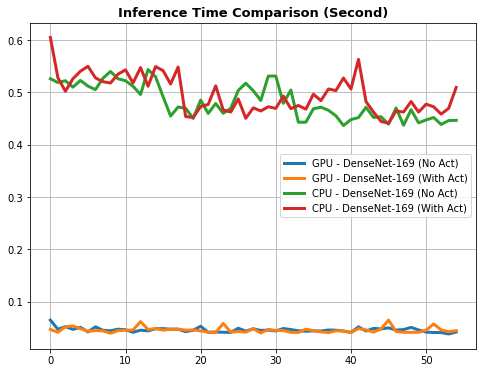

In [48]:
lw = 3
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.plot(gpu_it_noact[:55], label='GPU - DenseNet-169 (No Act)', lw=lw)
plt.plot(gpu_it_act[:55], label='GPU - DenseNet-169 (With Act)', lw=lw)
plt.plot(cpu_it_noact[:55], label='CPU - DenseNet-169 (No Act)', lw=lw)
plt.plot(cpu_it_act[:55], label='CPU - DenseNet-169 (With Act)', lw=lw)

plt.title(f"Inference Time Comparison (Second)", fontsize=13, fontweight='bold')
plt.legend()

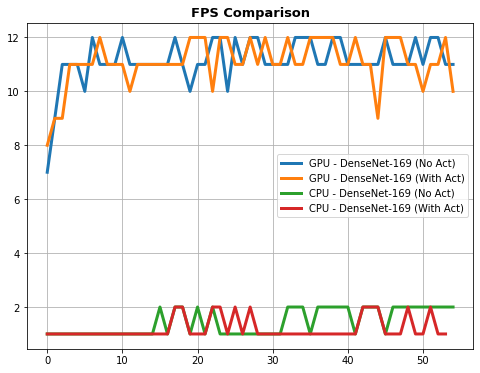

In [50]:
lw = 3
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.plot(np.array(gpu_fps_noact, dtype=np.float32)[:55], label='GPU - DenseNet-169 (No Act)', lw=lw)
plt.plot(np.array(gpu_fps_act, dtype=np.float32)[:55], label='GPU - DenseNet-169 (With Act)', lw=lw)
plt.plot(np.array(cpu_fps_noact, dtype=np.float32)[:55], label='CPU - DenseNet-169 (No Act)', lw=lw)
plt.plot(np.array(cpu_fps_act, dtype=np.float32)[:55], label='CPU - DenseNet-169 (With Act)', lw=lw)

plt.title(f"FPS Comparison", fontsize=13, fontweight='bold')
plt.legend()